# Carga y preparación de datos

In [1]:

import pandas as pd 

file_path = 'listings.csv' 
df = pd.read_csv(file_path)

columnas_utiles = [
    'id', 'name', 'host_id', 'host_name', 
    'neighbourhood_group', 'neighbourhood', 
    'latitude', 'longitude', 'room_type', 'price', 
    'minimum_nights', 'number_of_reviews', 'last_review', 
    'reviews_per_month', 'availability_365'
]

df_limpio = df[columnas_utiles].copy()


df_limpio['reviews_per_month'] = df_limpio['reviews_per_month'].fillna(0)

print("Datos cargados y 'df_limpio' creado con éxito.")


Datos cargados y 'df_limpio' creado con éxito.


In [2]:
# Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns



# IMPORTANTE: Para predecir, no podemos tener precios nulos.
df_modelo = df_limpio.dropna(subset=['price'])

# Feature Engineering
# Convertimos las columnas de texto (categóricas) en números

df_modelo = pd.get_dummies(df_modelo, columns=['room_type', 'neighbourhood_group'], drop_first=True)

# Celda 4: Seleccionar las "Pistas" (Features) y el "Objetivo" (Target)
# X -> Las "pistas" que usamos para predecir (features)
# y -> Lo que QUEREMOS predecir (el precio) (target)

# Elegimos solo columnas numéricas como "pistas"
features = [
    'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
    'reviews_per_month', 'availability_365',
    # Aquí están las nuevas columnas numéricas que ha creado get_dummies:
    'room_type_Private room', 'room_type_Shared room', 'room_type_Hotel room',
    'neighbourhood_group_POBLATS MARITIMS', 'neighbourhood_group_ENSEMBLE',
    'neighbourhood_group_CAMINS AL GRAU', 'neighbourhood_group_CIUTAT VELLA',
    'neighbourhood_group_EXTRAMURS', 'neighbourhood_group_LA SANTA CATALINA',
    'neighbourhood_group_NOU MESTALLA', 'neighbourhood_group_RUSSAFA',
    'neighbourhood_group_CAMINS AL GRAU', 'neighbourhood_group_EL CARMEN'
]


features_simples = [
    'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
    'reviews_per_month', 'availability_365'
]

X = df_modelo[features_simples]
y = df_modelo['price']

# Dividir los datos
Dividiremos la base de datos en dos, con un 75% de los datos entrenaremos al modelo y con el otro 25% lo testearemos

In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

print(f"Datos para entrenar (estudiar): {X_train.shape[0]} filas")
print(f"Datos para testear (examen): {X_test.shape[0]} filas")

Datos para entrenar (estudiar): 5234 filas
Datos para testear (examen): 1745 filas


# Entrenamiento con Regresión lineal (Modelo Tonto)

In [4]:

modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train) # Aquí es donde "aprende"


# Hacemos predicciones sobre el "examen" (X_test)
predicciones_lineales = modelo_lineal.predict(X_test)

# Comparamos las predicciones con los precios reales (y_test)
mae_lineal = mean_absolute_error(y_test, predicciones_lineales)

print(f"Error Medio Absoluto (Regresión Lineal): {mae_lineal:.2f} €")
# Esto significa: "De media, nuestro modelo simple se equivoca en X euros al predecir un precio"

Error Medio Absoluto (Regresión Lineal): 140.52 €


# Entrenamiento Random Forest (Modelo Listo)

In [5]:
# n_estimators=100 -> Usa 100 "árboles de decisión"

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=666, n_jobs=-1)
modelo_rf.fit(X_train, y_train) # ¡"Aprendiendo" con el modelo listo!

# Evaluar el modelo "listo"
predicciones_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, predicciones_rf)

print(f"Error Medio Absoluto (Regresión Lineal): {mae_lineal:.2f} €")
print(f"Error Medio Absoluto (Random Forest): {mae_rf:.2f} €")
print(f"\n¡Hemos mejorado la predicción en {mae_lineal - mae_rf:.2f} € de media!")

Error Medio Absoluto (Regresión Lineal): 140.52 €
Error Medio Absoluto (Random Forest): 126.02 €

¡Hemos mejorado la predicción en 14.50 € de media!


Como podemos ver, existen diferentes formas de entrenar a un modelo para mejorar su precisión

# USO 1: Predicción de precios
Usaremos ejemplos de airbnb para predecir sus precios de mercado.

In [6]:
# Apartamento central en Valencia con 10 reseñas
apartamento_nuevo = {
    'latitude': 39.4750,      
    'longitude': -0.3750,     
    'minimum_nights': 3,
    'number_of_reviews': 10, 
    'reviews_per_month': 1.5, 
    'availability_365': 200   # Disponible 200 días al año
}

# Lo convertimos a un DataFrame de Pandas (El modelo espera recibir los datos en este formato)
# Importante: usas [0] porque es una sola fila
index_nuevo = [0]
apartamento_df = pd.DataFrame(apartamento_nuevo, index=index_nuevo)


#  Usamos el modelo_rf que es el más preciso
precio_predicho = modelo_rf.predict(apartamento_df)

print(f"Predicción del precio para un nuevo apartamento")
print(f"Un apartamento con estas características costaría, según el modelo:")
print(f"===> {precio_predicho[0]:.2f} € por noche <===")

Predicción del precio para un nuevo apartamento
Un apartamento con estas características costaría, según el modelo:
===> 124.22 € por noche <===


# USO 2: Razonamiento del funcionamiento del modelo
Le preguntamos al modelo que características principales marcan el precio del apartamento

 Importancia de cada Característica 
longitude            0.422426
latitude             0.275177
availability_365     0.130829
minimum_nights       0.082739
reviews_per_month    0.048862
number_of_reviews    0.039966
dtype: float64


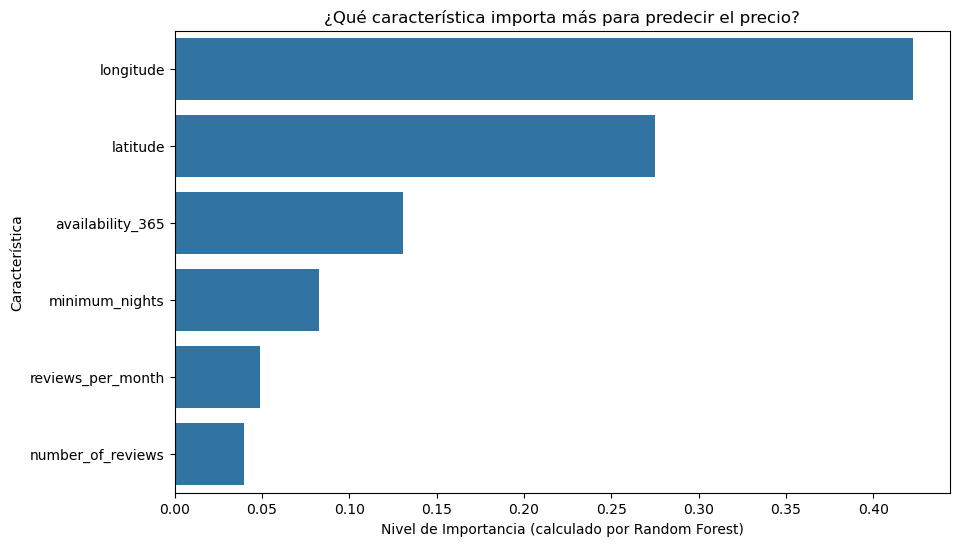

In [7]:
# ¿En qué se fija el modelo para decidir el precio? 

# Sacamos las "importancias" del modelo entrenado
importancias = modelo_rf.feature_importances_

# Creamos un DataFrame para verlo bonito
# Usamos 'features_simples' (la lista de columnas) como índice
feature_names = features_simples
importancia_df = pd.Series(importancias, index=feature_names).sort_values(ascending=False)

print(" Importancia de cada Característica ")
print(importancia_df)

# Graficamos

plt.figure(figsize=(10, 6))
sns.barplot(x=importancia_df.values, y=importancia_df.index)
plt.title('¿Qué característica importa más para predecir el precio?')
plt.xlabel('Nivel de Importancia (calculado por Random Forest)')
plt.ylabel('Característica')
plt.show()